## Experiment Result
The task is to predict the win/lose for blue team by the team performances in the first 10 minutes of a round in LOL game, using Decision Tree.  
Through experiments and tests,  
The best prediction accuracy score reaches 0.729.  
Scores are:  
Accuracy: 0.729251012145749      Precision: 0.7280534351145038      Recall: 0.7532082922013821      f1: 0.7404172731683649

In [48]:
from typing import (
    Set,
    List,
    Any,
    Dict,
)

import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

import seaborn as sb
import matplotlib.pyplot as plt

RANDOM_SEED = 2020 # random seed from sample code

### Data Preparation

LOL is a team-based confrontation game. The task is to predict if blue team can win by datas (performs) from red and blue team in the first 10 minutes of the game. 

---

Below are steps to read data from the provided .csv file as a panda.DataFrame:
#### 1. read data
#### 2. get the label classes (or the types of events to predict); here is "blueWins"; it should be binary
#### 3. frop fetures based on game nature: gameID, Firstblood(binary, one team takes it) should be irrelevant to the game result  
  
---

In [49]:
# read data from source file and build data frame
data_source: str = './data/high_diamond_ranked_10min.csv'
data_frame: pd.DataFrame = pd.read_csv(data_source, sep=',')
#display(data_frame)

# get the binary events(classes) based on the label index name
LABEL_NAME: str = "blueWins"  # string name for the label (event to predict)
label_events: List[int] = list(data_frame[LABEL_NAME].unique())  # label classes in ID3; here is [0, 1]

# drop features that are irrelevant to the task based on the game nature
irrelevant: List[str] = ["gameId", "blueFirstBlood", "redFirstBlood"]
if "gameId" in data_frame.columns:
    data_frame.drop(columns=[column for column in irrelevant if column in data_frame.columns], inplace=True)
display(data_frame)
print(label_events)

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,9,6,11,0,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,5,5,5,0,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,7,11,4,1,1,0,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,4,5,5,1,0,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,6,6,6,0,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,7,4,5,1,1,0,0,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,1,54,0,6,4,8,1,1,0,0,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,0,23,1,6,7,5,0,0,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,0,14,4,2,3,3,1,1,0,0,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


[0, 1]


### Data Cleanup

Although data here is clean, for practicing purpose, below section goes through some normal clean up steps.  
Contains: remove duplicants/missing data/invalid data(based on the task)
  
---

In [50]:
# remove duplicants in data frame
data_frame.drop_duplicates(inplace=True)
# remove constant features
data_frame = data_frame.loc[:, (data_frame != data_frame.iloc[0]).any()]
# check if exists any missing data
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9879 entries, 0 to 9878
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueKills                     9879 non-null   int64  
 4   blueDeaths                    9879 non-null   int64  
 5   blueAssists                   9879 non-null   int64  
 6   blueEliteMonsters             9879 non-null   int64  
 7   blueDragons                   9879 non-null   int64  
 8   blueHeralds                   9879 non-null   int64  
 9   blueTowersDestroyed           9879 non-null   int64  
 10  blueTotalGold                 9879 non-null   int64  
 11  blueAvgLevel                  9879 non-null   float64
 12  blueTotalExperience           9879 non-null   int64  
 13  blu

Upper suggests that there are no features with missing data;  
In general, if missing data exist, we need to drop the feature columns with too many missing data.  
Here, no further modification needs to be applied.

In [51]:
# find invalid data based on the nature of the LOL game (may vary depends on the task)
invalid: pd.DataFrame = data_frame[
    (data_frame["blueWardsPlaced"] < data_frame["redWardsDestroyed"])|
    (data_frame["redWardsPlaced"] < data_frame["blueWardsDestroyed"])|
    (data_frame["blueKills"] != data_frame["redDeaths"])|
    (data_frame["redKills"] != data_frame["blueDeaths"])
]
invalid.empty

True

Above section finds invalid data based on the nature of the LOL game (may vary depends on the task);  
The result shows that there is no invalid data to clean up.  

---

### Features Select
Decision tree ID3 is based on features. Constructing a data frame with features that are 
most relevant to the tasks can help with the learning results.  

---

At this stage, except the label feature, there are 36 features in total. 
Decision tree ID3 performs better when feature amount is under 20. It is in need of reduce features to a reasonable amount.  

By observing the data, we noticed that the features mostly come in pairs.  
Since LOL is a confrontation game, the differences between red team and blue team can have more impact over the winning.

---

*Step 1*: add difference data between two oppose features (blue-red) into the existing data frame  
*Step 2*: remove highly-correlated features  

---

In [52]:
def add_oppose_between_feature_pair(data_frame: pd.DataFrame) -> None:
    """features are in pair for blue and red team;
    as this is a confrontation game, the diff between two oppose features are more irrelavant to the game results;
    this function adds these diffs in"""
    local_data_frame = data_frame.copy()
    
    # use red team features to query the base name for making subtraction
    feature_names = [column[3:] for column in local_data_frame.columns if column.startswith("red")]
    for name in feature_names:
        blue_feature = "blue"+ name
        red_feature = "red" + name
        if blue_feature in local_data_frame.columns:
            # add the subtraction feature into the data frame
            local_data_frame["BvR"+name] = local_data_frame[blue_feature] - local_data_frame[red_feature]
            # remove the original pair as only the difference between is important
            local_data_frame.drop(columns = [blue_feature, red_feature], inplace=True)
    return local_data_frame
        
# test this method:
# feature_added_data_frame = add_oppose_between_feature_pair(data_frame)
# print(feature_added_data_frame.shape)

In [53]:
def display_heatmap(data_frame: pd.DataFrame) -> None:
    # display for better visulization
    # ref: https://www.educba.com/seaborn-heatmap-size/
    # ref: https://stackoverflow.com/questions/39409866/correlation-heatmap
    plt.figure(figsize = (10,10))
    sb.heatmap(data_frame, cmap=sb.cubehelix_palette(as_cmap=True), annot=True, fmt=".2f")

In [54]:
def get_correlated_features(data_frame: pd.DataFrame, correlated_threshold: float = 0.8) -> Set[str]:
    # ref: https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
    # todo: can we do adaptive threshold???
    correlated_features = set()
    
    # data here is all numeric so no need to remove non-numeric features
    # get the collerated matrix between pair of features
    data_frame_no_labels = data_frame.drop(columns = [LABEL_NAME])
    correlation_matrix = data_frame_no_labels.corr().abs()
    display_heatmap(correlation_matrix)
    
    # loop though colums and add feature into set if any correlated value is larger than threshold
    for i in range(0, len(correlation_matrix.columns)):
        for j in range(0, i):
            if correlation_matrix.iloc[i, j] > correlated_threshold:
                correlated_features.add(correlation_matrix.columns[i])
    return correlated_features

# test this method:
# correlated_features = get_correlated_features(feature_added_data_frame, 0.87)

In [55]:
# method 1: add then clean up
def add_then_cleanup_features(data_frame: pd.DataFrame, correlated_threshold: float = 0.8) -> pd.DataFrame:
    feature_added_data_frame = add_oppose_between_feature_pair(data_frame)
    correlated_features = get_correlated_features(feature_added_data_frame, correlated_threshold)
    print(correlated_features)
    return feature_added_data_frame.drop(columns = correlated_features)


In [56]:
# method 2: drop (based on sample codes), add, then clean up again --- NOT USED
def follow_code_sample(data_frame: pd.DataFrame, correlated_threshold: float = 0.8) -> pd.DataFrame:
    drop_features = ['blueGoldDiff', 'redGoldDiff', 
                 'blueExperienceDiff', 'redExperienceDiff', 
                 'blueCSPerMin', 'redCSPerMin', 
                 'blueGoldPerMin', 'redGoldPerMin']
    new_data_frame = data_frame.drop(columns = [column for column in drop_features if column in data_frame.columns])
    new_data_frame = add_oppose_between_feature_pair(new_data_frame)
    correlated_features = get_correlated_features(new_data_frame, correlated_threshold)
    print(correlated_features)
    return new_data_frame.drop(columns = correlated_features)

Method 2 above is based on the assignment example code.
However, Method 1 is chosen since there are some correlated features kept by method 2;
And there are some features that can affect the game (game experience) being dropped by method 2.

{'BvRExperienceDiff', 'BvRDeaths', 'BvRGoldPerMin', 'BvRGoldDiff', 'BvRCSPerMin'}


,blueWins,BvRWardsPlaced,BvRWardsDestroyed,BvRKills,BvRAssists,BvREliteMonsters,BvRDragons,BvRHeralds,BvRTowersDestroyed,BvRTotalGold,BvRAvgLevel,BvRTotalExperience,BvRTotalMinionsKilled,BvRTotalJungleMinionsKilled
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,-0.079664,0.101731,0.046260,-0.017006,-0.023180,-0.051119,0.027938,0.008402,14.414111,-0.009313,-33.620306,-0.649661,-0.803421
std,0.500024,25.960582,2.854910,4.195489,5.766787,1.067934,0.878945,0.589292,0.324835,2453.349179,0.478434,1920.370438,30.942675,14.274733
min,0.000000,-260.000000,-23.000000,-17.000000,-25.000000,-2.000000,-1.000000,-1.000000,-2.000000,-10830.000000,-2.600000,-9333.000000,-120.000000,-72.000000
25%,0.000000,-4.000000,-1.000000,-3.000000,-4.000000,-1.000000,-1.000000,0.000000,0.000000,-1585.500000,-0.400000,-1290.500000,-21.000000,-10.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,-28.000000,-1.000000,0.000000
75%,1.000000,4.000000,1.000000,3.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1596.000000,0.200000,1212.000000,20.000000,8.000000
max,1.000000,234.000000,23.000000,16.000000,23.000000,2.000000,1.000000,1.000000,4.000000,11467.000000,2.400000,8348.000000,127.000000,64.000000


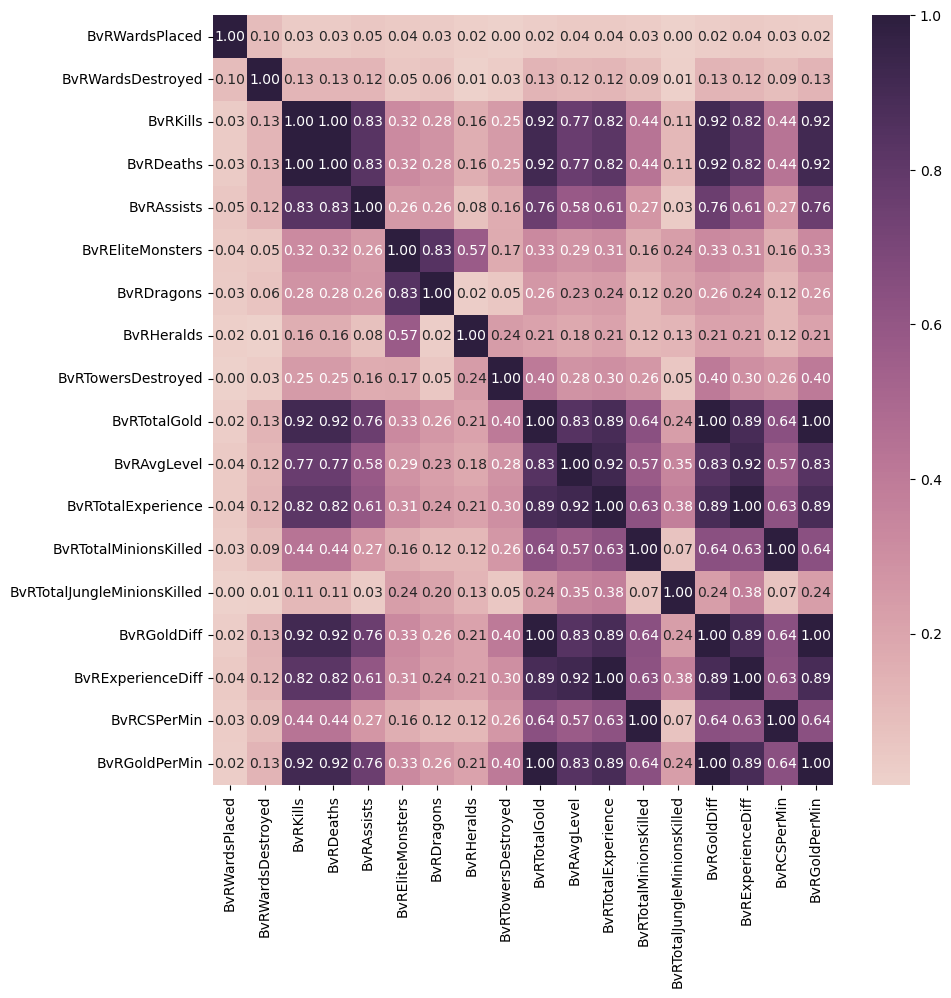

In [57]:
data_frame = add_then_cleanup_features(data_frame, 0.95)
data_frame.describe()

Highly-correlated features(threshold=0.85) are:  
'BvRExperienceDiff', 'BvRGoldDiff', 'BvRGoldPerMin', 'BvRTotalGold', 'BvRTotalExperience', 'BvRDeaths', 'BvRCSPerMin';  
For example, the amount of kills and death would always be the same.  

By removing these redundant features, we reduce the feature amount to 11 (except label).

### Discrete Data

Here qcut is used (similar to equal-frequency binning).

In [58]:
def discrete_by_frequency(data_frame: pd.DataFrame, freq_threshold: int) -> pd.DataFrame:
    discrete_data_frame: pd.DataFrame = data_frame.copy()
    
    # if frequency is too low, quit discrete
    for column in data_frame.loc[:, data_frame.columns != LABEL_NAME]:
        if len(data_frame[column].unique()) < freq_threshold:
            continue
        discrete_data_frame[column] = pd.qcut(data_frame[column], freq_threshold, precision=0, labels=False, duplicates='drop')
    return discrete_data_frame

discrete_data_frame = discrete_by_frequency(data_frame, freq_threshold=3)
# best is 3 so far; see tests/validation section below
display(discrete_data_frame)

,blueWins,BvRWardsPlaced,BvRWardsDestroyed,BvRKills,BvRAssists,BvREliteMonsters,BvRDragons,BvRHeralds,BvRTowersDestroyed,BvRTotalGold,BvRAvgLevel,BvRTotalExperience,BvRTotalMinionsKilled,BvRTotalJungleMinionsKilled
0,0,2,0,2,2,1,0,0,0,1,0,1,1,0
1,0,1,1,1,2,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,2
3,0,2,0,1,0,1,0,1,0,0,1,1,0,2
4,0,2,2,1,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,0,0,2,0,1,0,0,0,2,2,2,0,2
9875,1,2,0,1,2,1,0,0,0,1,1,2,2,0
9876,0,2,1,1,0,0,0,0,0,0,0,0,0,0
9877,0,0,1,1,1,1,0,0,0,1,0,0,0,2


### Prepare Sample Sets

---

In this example, the label needs to be separated away from features. 
As the task is to use feature data to predict the associated labels.  
At least two sample sets, train sets and test sets, are mandatory.  

The code frame below randomly takes 20% of the overall data as the test set, the rest as train set.  
Python module "sklearn" provides a method "train_test_split" for this occasion. 
I/O for sklearn are usually numpy arrays, extraction or conversion between pandas dataframe and numpy array needs to be done.  

---

In [59]:
all_y = discrete_data_frame[LABEL_NAME].values  # all label values
feature_names = discrete_data_frame.columns[1:]  # all feature names
all_x = discrete_data_frame[feature_names].values # all features' values

# split data frame to train set and test set use sklearn train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)

# check the sets are splitted correctly
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((9879,), (9879, 13), (7903, 13), (1976, 13), (7903,), (1976,))

### Decision Tree with ID3

In [60]:
# 定义决策树类
class DecisionTree(object):
    def __init__(self, classes, features, max_depth=10, min_samples_split=10, split_method="IG"):
        
        """
        classes: label classes, in this case is [0, 1]
        features: names of all features
        max_depth: max depth of the tree
        min_samples_split: threshold sample amount to stop splitting if the assiciated feature is too small
        split_method: IG or Gini to select features to split on
        """
        
        self.classes = classes
        self.features = features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.split_method = split_method
        
        self.root = None  # root node; when start to build the tree, it is empty
        
        self.tree = {}
        for i in range(0, max_depth):
            self.tree[i+1] = []
    
    def get_probability_count(self, label: np.array) -> List[int]:
        """
        Get the occurence of class types in the label values array;
        label: [n*1] array for label values; based on current feature
        
        return:
        label_class_counts: [label=0 count, label=1 count]
        """
        label_class_counts = []
        for label_class_type in self.classes:
            label_class_counts.append(list(label).count(label_class_type))
        return label_class_counts

    
    def get_entropy(self, label: np.array) -> float:
        """
        Get entropy(or impurity) of the given label values
        label: [n*1] array for label values; based on current feature
        
        return: float
        """
        # step 1: get occurence weights
        amount = len(list(label))
        label_class_counts = self.get_probability_count(label)  # [label=0 count, label=1 count]
        # step 2: use occurence weights to get entropy
        # if all count is 0, return 0; if all count is the same, return 1;
        if all(class_count == label_class_counts[0] for class_count in label_class_counts):
            if label_class_counts[0] == 0:
                return 0.0
            else:
                return 1.0
        weights = [count/amount for count in label_class_counts]
        return -sum([w * np.log2(w) for w in weights if w > 0])
    
    
    def get_gini(self, label: np.array) -> float:
        """
        Get gini of the given label values
        label: [n*1] array for label values; based on current feature
        
        return: float
        """
        # step 1: get occurence weights
        amount = len(list(label))
        label_class_counts = self.get_probability_count(label)  # [label=0 count, label=1 count]
        # step 2: use occurence weights to get gini
        weights = [count/amount for count in label_class_counts]
        return 1-sum(weight*weight for weight in weights)


    def get_IG(self, feature, label) -> List[Any]:
        
        """
        Calculate IG for different sub class values for a feature
        feature: [n*1] array for feature-to-be-split values
        label: [n*1] array for label values; based on current feature/feature's subclass(subnode)
        
        return:
        [IG, {feature_subclass(subnode): [indices]}]
        """
        
        current_entropy = self.get_entropy(label)

        # {feature_subclass(subnode): [indices]}, this is to help access sub class(node) of features 
        feature_index = {}
        for index, feature_value in enumerate(feature):
            if feature_value not in feature_index:
                feature_index[feature_value] = []
            feature_index[feature_value].append(index)

        # candidate split features' entropy (weighted)
        entropy = 0
        for key in feature_index.keys():
            label_values = label[feature_index[key]]
            entropy += self.get_entropy(label_values) * len(label_values)/len(label)
        return [current_entropy-entropy, feature_index]
    
    
    def get_weighted_gini_index(self, feature, label) -> List[Any]:
        # https://towardsdatascience.com/decision-trees-explained-entropy-information-gain-gini-index-ccp-pruning-4d78070db36c
        
        # {feature_subclass(subnode): [indices]}, this is to help access sub class(node) of features 
        feature_index = {}
        for index, feature_value in enumerate(feature):
            if feature_value not in feature_index:
                feature_index[feature_value] = []
            feature_index[feature_value].append(index)
            
        amount = len(label)
        weighted_gini_sum = 0
        for feature_value in feature_index.keys():
            weight = len(feature_index[feature_value])/amount
            weighted_gini_sum += weight * self.get_gini(label)
        return [weighted_gini_sum, feature_index]
    

    def build_tree(self, feature, label, depth, used_features_indices) -> List[Any]:
        
        """
        Actual method to build the decision tree. This is a recursive function.
        feature: [n*m] array for feature values; in the first recursion, this is the x_train
        label: [n*1] array for label values; in the first recursion, this is the y_train
        depth: int; current tree depth; if reaches max depth, stop splitting
        used_features: List[int]; trace by index in all features list can save string and index conversion
        
        return:
        the return records either the decision(most happen labels) if the split stops;
        ot return the feature_index for further splitting;
        
        The split stops when:
        (1) there is no sample fits current conditions (features & subnodes)
        (2) tree depth reaches the max depth predifined
        (3) the amount of samples for the sub class is too small
        
        feature_index: {feature_subclass(subnode): [indices]} from get_IG()
        """
        # stop splitting and return the decsion(label value)
        label_class_count = self.get_probability_count(label)
        most_happen_label = self.classes[label_class_count.index(max(label_class_count))]
        if depth > self.max_depth or len(label)<self.min_samples_split:
            return [most_happen_label]
        

        # 2. step through each unused features and determine the best feature with IG
        if self.split_method == "IG":
            best_feature_index = -1
            max_IG = -1
            best_feature_class_index = {}
            for index in range(0, len(self.features)):
                if index in used_features_indices:
                    continue
                IG_and_feature_index = self.get_IG(feature[:, index], label)
                if IG_and_feature_index[0] > max_IG:
                    best_feature_index = index
                    max_IG = IG_and_feature_index[0]
                    best_feature_class_index = IG_and_feature_index[1]
                    
        if self.split_method == "GiniIndex":
            best_feature_index = -1
            max_IG = 1  # ig use gini index, we want the feature with min gini index 
            best_feature_class_index = {}
            for index in range(0, len(self.features)):
                if index in used_features_indices:
                    continue
                gini_and_feature_index = self.get_weighted_gini_index(feature[:, index], label)
                if gini_and_feature_index[0] < max_IG:
                    best_feature_index = index
                    max_IG = gini_and_feature_index[0]
                    best_feature_class_index = gini_and_feature_index[1]
            
            
        if best_feature_index < 0:
            # if there is no best feature, ends splitting
            return [most_happen_label]
        
        # step through each subclass(node) for the feature and find its next best feature
        sub_nodes = {}
        used_features_under_the_branch = used_features_indices + [best_feature_index]
        for feature_class in best_feature_class_index:
            feature_class_indices = best_feature_class_index[feature_class]
            sub_nodes[feature_class] = self.build_tree(
                feature[feature_class_indices, :],
                label[feature_class_indices], 
                depth + 1, 
                used_features_under_the_branch
            )
        self.tree[depth].append(self.features[best_feature_index])
        return [best_feature_index, sub_nodes, most_happen_label]

    
    def traverse_node(self, node, feature) -> int:
        """
        node: List[Any]
        If the node is a node that has no split branches under it, the list would contain the most happen label type;
        Else, recursively find the node until it meets the occasion 
        """
        # input sample's feature amount must be the same as the train feature amount
        assert len(self.features) == len(feature) 

        if len(node)==1:
            return node[0]
        feature_value = feature[node[0]]
        if feature_value in node[1]:
            return self.traverse_node(node[1][feature_value], feature)
        return node[-1]

        
    def fit(self, feature, label) -> None:
        assert len(self.features) == len(feature[0])
        self.root = self.build_tree(feature, label, 1, [])

    def predict(self, feature) -> List[int]:
        if len(feature.shape) == 1:
            return self.traverse_node(self.root, feature)
        return [self.traverse_node(self.root, f) for f in feature]
    

In [61]:
# train decision tree
decision_tree = DecisionTree(classes=label_events, features=feature_names, 
                             max_depth=3, min_samples_split=150, split_method="IG")
decision_tree.fit(x_train, y_train)

# print out decision tree
print("Result of the decision tree")
for depth in decision_tree.tree.keys():
    print("Tree depth: {}".format(depth))
    print([node for node in decision_tree.tree[depth]])
# run predict on x_test
predict_labels = np.array(decision_tree.predict(x_test))

# measure the prediction result
# reference: https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
# reference: https://blog.csdn.net/u010417185/article/details/88065960
accuracy = accuracy_score(y_test, predict_labels)
precision = precision_score(y_test, predict_labels)
recall = recall_score(y_test, predict_labels)
f1 = f1_score(y_test, predict_labels)
print("Accuracy: {}      Precision: {}      Recall: {}      f1: {}".format(accuracy, precision, recall, f1))

Result of the decision tree
Tree depth: 1
['BvRTotalGold']
Tree depth: 2
['BvRTotalExperience', 'BvREliteMonsters', 'BvRTotalExperience']
Tree depth: 3
['BvREliteMonsters', 'BvRTotalMinionsKilled', 'BvRAvgLevel', 'BvRTotalExperience', 'BvREliteMonsters', 'BvRWardsDestroyed', 'BvREliteMonsters']
Accuracy: 0.729251012145749      Precision: 0.7280534351145038      Recall: 0.7532082922013821      f1: 0.7404172731683649


---

## Adjust Model  and Learning
There are key parameters that can affect the prediction accuracy.

---
#### In Data Model:
(1) threshold for correlation score to remove redundant features  
(2) discrete threshold

#### In Decision Tree Training:
(1) max depth of the tree  
(2) threshold sample amount to stop splitting  
(3) best-feature-select methods: Entropy-IG vs GiniIndex  


---


### Validation on correlation score threshold to select features

In [ ]:
# starts from a loose condition
threshold_distance = 0.05
threshold = 0.95
thresholds = [threshold]
while threshold>=0.4:
    threshold -= threshold_distance
    thresholds.append(threshold)

accuracy_scores = {}
for split_method in ["IG", "GiniIndex"]:
    accuracy_scores[split_method] = []
    for threshold in thresholds:
        # read data frame again for processing
        data_frame: pd.DataFrame = pd.read_csv(data_source, sep=',')
        # drop features that are irrelevant to the task based on the game nature
        irrelevant: List[str] = ["gameId", "blueFirstBlood", "redFirstBlood"]
        if "gameId" in data_frame.columns:
            data_frame.drop(columns=[column for column in irrelevant if column in data_frame.columns], inplace=True)
        # clean up data
        data_frame = add_then_cleanup_features(data_frame, threshold)
        # discrete data
        discrete_data_frame = discrete_by_frequency(data_frame, freq_threshold=5)
        # split data for train and test
        all_y = discrete_data_frame[LABEL_NAME].values  # all label values
        feature_names = discrete_data_frame.columns[1:]  # all feature names
        all_x = discrete_data_frame[feature_names].values # all features' values
        # split data frame to train set and test set use sklearn train_test_split
        x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)
        # train the tree
        decision_tree = DecisionTree(classes=label_events, features=feature_names, 
                                 max_depth=10, min_samples_split=1, split_method=split_method)
        decision_tree.fit(x_train, y_train)
        # predict
        validate_predict_labels = np.array(decision_tree.predict(x_test))
        accuracy = accuracy_score(y_test, validate_predict_labels)
        accuracy_scores[split_method].append(accuracy)
print(accuracy_scores)
            

Text(0.5, 1.0, 'Accuracy -- min sample:1, tree depth:10')

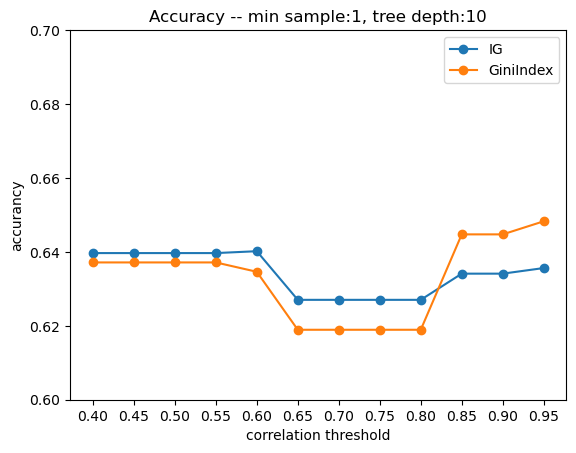

In [16]:
correlation_threshold = thresholds
y_1 = accuracy_scores["IG"]
y_2 = accuracy_scores["GiniIndex"]
plt.ylim(0.6, 0.7)

plt.xticks(correlation_threshold)  
plt.plot(correlation_threshold, y_1, marker='o', label='IG')
plt.plot(correlation_threshold, y_2, marker='o', label='GiniIndex')
plt.legend()
 
plt.xlabel('correlation threshold')
plt.ylabel("accurancy")
plt.title("Accuracy -- min sample:1, tree depth:10")

In general, loose correlation score thresholds performs better under a tree with maximum depth 10, and minimum split sample amount 1.  

Before threshold gets below 0.85, splitting with Gini Index gives a better result, compared to Information Gain; After getting lower than 0.85, Information Gain produces higher prediction accuracy. 
Once the correlation threshold gets below 0.65, accuracy scores for both two splitting algorithms climb up again.

Thus, in the later testing for parameter adjusting, except changing only one parameter under two splitting algorithms, it's also essential to compare performances with different correlation thresholds.  

Based on the analysis above, threshold=0.85, 0.65, 0.6 will be chosen as test anchor points. As they represent three different trends for prediction accuracy. 

### Validation on data discrete frequency threshold

Text(0.5, 1.0, 'Accuracy -- min sample:1, tree depth:10, GiniIndex')

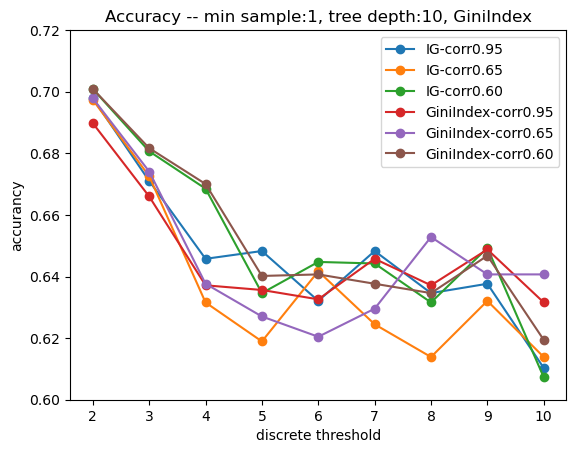

In [100]:
discrete_threshold = [2, 3, 4, 5, 6, 7, 8, 9, 10]
y_1 = [0.6978744939271255, 0.6710526315789473, 0.645748987854251, 0.6482793522267206, 0.632085020242915, 
       0.6482793522267206, 0.6346153846153846, 0.6376518218623481, 0.6103238866396761]
y_2 = [0.6973684210526315, 0.6725708502024291, 0.631578947368421, 0.6189271255060729, 0.6417004048582996, 
       0.6244939271255061, 0.6138663967611336, 0.632085020242915, 0.6138663967611336]
y_3 = [0.7009109311740891, 0.680668016194332, 0.6685222672064778, 0.6346153846153846, 0.6447368421052632, 
       0.6442307692307693, 0.631578947368421, 0.6492914979757085, 0.6072874493927125]
y_4 = [0.6897773279352226, 0.6659919028340081, 0.6371457489878543, 0.6356275303643725, 0.6325910931174089, 
       0.645748987854251, 0.6371457489878543, 0.6487854251012146, 0.631578947368421]
y_5 = [0.6978744939271255, 0.6740890688259109, 0.6376518218623481, 0.6270242914979757, 0.6204453441295547, 
       0.6295546558704453, 0.652834008097166, 0.6406882591093117, 0.6406882591093117]
y_6 = [0.7009109311740891, 0.6816801619433198, 0.6700404858299596, 0.6401821862348178, 0.6406882591093117, 
       0.6376518218623481, 0.6346153846153846, 0.6467611336032388, 0.6194331983805668]
plt.ylim(0.6, 0.72)

plt.xticks(discrete_threshold)  
plt.plot(discrete_threshold, y_1, marker='o', label='IG-corr0.95')
plt.plot(discrete_threshold, y_2, marker='o', label='IG-corr0.65')
plt.plot(discrete_threshold, y_3, marker='o', label='IG-corr0.60')
plt.plot(discrete_threshold, y_4, marker='o', label='GiniIndex-corr0.95')
plt.plot(discrete_threshold, y_5, marker='o', label='GiniIndex-corr0.65')
plt.plot(discrete_threshold, y_6, marker='o', label='GiniIndex-corr0.60')
plt.legend()
 
plt.xlabel('discrete threshold')
plt.ylabel("accurancy")
plt.title("Accuracy -- min sample:1, tree depth:10, GiniIndex")

Overall, there is a downtrend on accuracy scores whilst the frequency threshold for discretizing data increases.  

Once the frequency threshold gets greater than 4, fluctuation happens on the prediction performances for both Gini Index and IG, which suggests low stability.  
The second peak for accuracy scores happens when frequency threshold gets to 9(IG) and 8(Gini Index).
The graph also suggests that the fluctuation with Gini Index is smoother than IG.  

It is also an interesting fact that for both Gini index and IG,
under the same frequency threshold, correlation threshold=0.6 performs better.

Before frequency threshold gets greater than 3,  
differences between performances for split algorithms under the same correlation score are not
as obvious as when frequency threshold increases.

When discrete data frequency threshold equals to 3, and correlation threshold equals to 0.65 or 0.6,
accuracy scores for IG and Gini Inedx are close.  

When correlation is 0.95, IG and Gini Index predictions have obvious differences with the same set of data.


### Summary on Data Processing

---

With the decision tree defined to use features and samples in the precossed data set as much as possible (max depth=10, minimum split threshold = 1),   
discreting data with higher frequency does not gaurantee a good prediction performance.  
When discrete threshold = 2 or 3, IG and Gini Index performance results with different correlation thresholds are close. 
Besides, Information Gain and Gini Index can affect the prediction results massively.  

This upper discovery is useful for later parameter adjusting tests on the decision tree.

---

For decision tree tests,  
Correlation Threshold = 0.95, 0.6  
Discrete Frequency Threshold = 2, 3, 9  
will be used as anchor points.

## Validation on Decision Tree

In [47]:
# test anchor points
correlation_thresholds = [0.60, 0.95]
discrete_thresholds = [2, 3, 9]

### Validation on tree max depth

In [ ]:
k = 10
max_depth_list = [1,2,3,4,5,6,7,8,9,10]
accuracy_for_split_methods = {}

for split_method in ["IG", "GiniIndex"]:
    mean_accuracy_for_depth = []
    for max_depth in max_depth_list:
        accuracy_scores = []
        for k_value in range(1, k):
            # split train set to train set and validation set based on k
            validate_indices = [index for index in range(0, len(y_train)) if index%k==k_value]
            train_indices = [index for index in range(0, len(y_train)) if index%k!=k_value]

            x_train_values = x_train[train_indices]
            y_train_values = y_train[train_indices]
            x_validate_values = x_train[validate_indices]
            y_validate_values = y_train[validate_indices]
        
            # train on the train sets
            decision_tree = DecisionTree(classes=label_events, features=feature_names, 
                                 max_depth=max_depth, min_samples_split=1, split_method=split_method)
            decision_tree.fit(x_train_values, y_train_values)
            # predict on validation set
            validate_predict_labels = np.array(decision_tree.predict(x_validate_values))
            # get accuracy score
            accuracy_scores.append(accuracy_score(y_validate_values, validate_predict_labels))
        mean_accuracy = np.mean(accuracy_scores)
        mean_accuracy_for_depth.append(mean_accuracy)
        accuracy_for_split_methods[split_method] = mean_accuracy_for_depth
print(accuracy_for_split_methods)

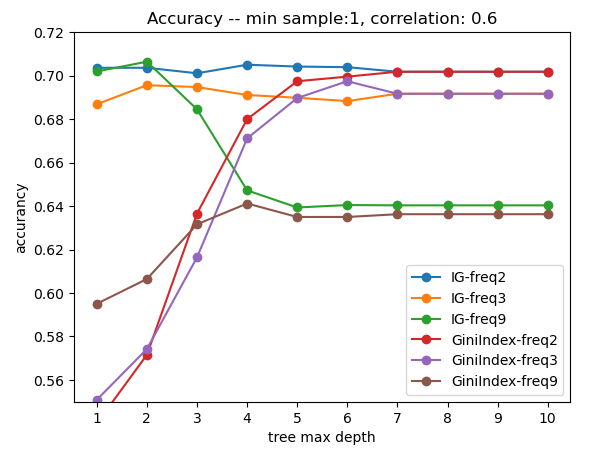  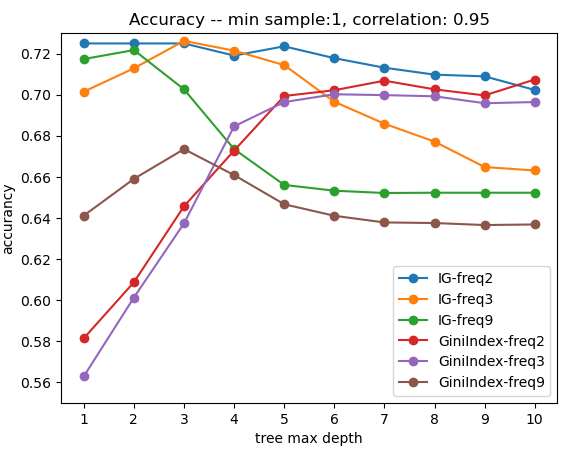

By comparing two graphs, it came to notice that in this example, Information Gain performs generally better than Gini Index.  

Under the same correlation threshold, if discrete data with a comparatively high frequency(9), accuracy is generally lower. This suggests that high discrete frequency should use small max depth for the tree, otherwise the training will overfit data.

For correlation=0.6,
as the tree max depth reaches to 5, Gini and IG algorithms performance under the same discrete frequency gets closer to each other and overlaps after max tree depth to 7.  
The reason is we set a tight correlation threshold, and drop too many features. Thus, the tree layer gets empty as the depth gets deeper,
due to there being more features for splitting.

The accuracy peak for correlation=0.95 is higher than for correlation=0.65.
So, we will choose correlation=0.95 for further testing.

For correlation=0.95,  
Best accuracy for IG:
frequency=3 maxdepth=3 or frequency=2 maxdepth=5  
Best accuracy for Gini Index:  
frequency=2 maxdepth=10  

However, the result can also be affected by minimum sample amount.  
The upper three will be tested under different minimum sample amount for splitting.

### Validation on minmum sample

Test how minimum sample amount can affect the accuracy in the three conditions in the above analysis.

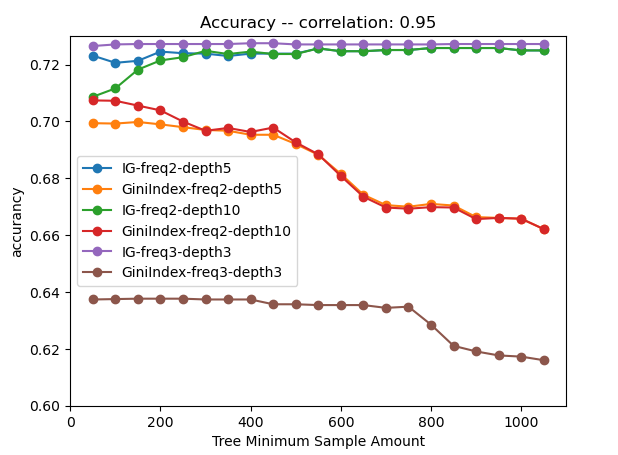

## Summary
See from the graph, the best prediction accuracy happens when:  
Correlation Threshold: 0.95, Discrete Frequency: 3, Tree Max Depth:3, Algorithm: Information Gain.  
Under this set of parameters, the minimum sample amount for splitting does not make a huge difference.

In general terms, under this task with the given data, Decision Tree with Entropy-IG generates more reliable predictions than with Gini Index.  

The minimum sample amount has a comparatively large impact over Gini Index algorithm.